<a href="https://colab.research.google.com/github/BurovNV/MyRepo/blob/main/Dim_reduct_TSVD_LSA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Аналог PCA, но лучше работает на разреженных данных, в том числе текст в формате мешка слов.

In [5]:
# импорт
import numpy as np
from sklearn import datasets
# StandardScaler не нужен - работаем с картинками
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import TruncatedSVD
from scipy.sparse import csr_matrix
import matplotlib.pyplot as plt
%matplotlib inline

In [16]:
# данные
digits = datasets.load_digits()
X = digits.data
y = digits.target
X.shape

(1797, 64)

In [17]:
# сколько классов - всего 6
y.max()

9

In [4]:
# масштабируем данные
scaler = MinMaxScaler()
scaler.fit(X)
X_std = scaler.transform(X)

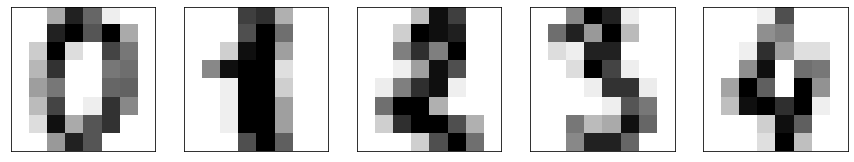

In [19]:
# первые 5 картинок
plt.figure(figsize=(15, 3))
for i in range(5):
  plt.subplot(1, 5, i+1)
  plt.imshow(X_std[i].reshape(-1, 8), 
             cmap=plt.cm.gray_r)
  plt.xticks([])
  plt.yticks([])

In [20]:
# создаем разреженную матрицу признаков
csr_X = csr_matrix(X_std)

In [32]:
# так как нет настройки по объему дисперсии, нужно или выбирать кол-во
# фичей для сжатия или писать функцию для автонастройки
# сжатия по кол-ву фичей
tsvd = TruncatedSVD(n_components=10,   # кол-во измерений
                    n_iter=5,          # итераций прогона
                    random_state=42)

tsvd.fit(csr_X)

TruncatedSVD(algorithm='randomized', n_components=10, n_iter=5, random_state=42,
             tol=0.0)

In [33]:
# вывод объясненной дисперсии
tsvd.explained_variance_ratio_

array([0.02563247, 0.19412149, 0.16204903, 0.11317505, 0.08382352,
       0.05153749, 0.04546571, 0.03552703, 0.02869572, 0.02574399])

In [61]:
# пишем функцию для настройки кол-ва фичей по дисперсии
def select_by_variance(data,                       # данные
                       goal_variace):              # целевая дисперсия
  # сначала возьмем исходное кол-во фичей
  original_n_components = data.shape[1]
  # далее от него отнимем 1, иначе алгоритм работать не будет
  n_components = original_n_components - 1
  # исходная объясненная на данный момент дисперсия
  total_variance=0.0
  tsvd = TruncatedSVD(n_components=n_components,   # кол-во измерений
                      n_iter=7,                    # итераций прогона
                      random_state=42)
  tsvd.fit(data)
  
  # Задать исходное количество признаков
  n = 0
  for exp_var in tsvd.explained_variance_ratio_:
    total_variance += exp_var
    n += 1
    if total_variance >= goal_variace:
      break
  tsvd_ = TruncatedSVD(n_components=n,             # кол-во после подгонки
                       n_iter=7,                   # итераций прогона
                       random_state=42)
  data = tsvd_.fit_transform(data)                 # пережмем данные в n фичей
  return (data, tsvd.explained_variance_ratio_[:n])

In [62]:
# вызов
tsvd_data, exp_variance = select_by_variance(csr_X, 0.55)

In [63]:
# проверим
tsvd_data.shape

(1083, 5)

In [64]:
exp_variance

array([0.02563247, 0.19412149, 0.16204903, 0.11317505, 0.08382352])

In [65]:
exp_variance.sum()

0.5788015665567053